# Embedding

## Import Data

In [ ]:
!pip install biopython
!pip install hdbscan

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 4.7MB 4.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2307103 sha256=a0fb82961cdf90d0d1e93fbb62edaea84e5e7445b090a9e5d67e0d7875af487e
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Biopython
import Bio
from Bio import Entrez
from Bio import Medline
# 전처리 관련
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# 임베딩
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
# 차원축소
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# clustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
import hdbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
Entrez.email = "neo.ewha@gmail.com"
journal_list = ["BMC Bioinformatics", "Genomics & Informatics", "Algorithms for Molecular Biology : AMB", "BMC Systems Biology", "Journal of Computational Biology", "Briefings in Bioinformatics", "BMC Genomics", "Nucleic Acids Research", "American Journal of Human Genetics", "Oncogenesis", "Disease Markers", "Microarrays"]
current_dir = "/content/gdrive/My Drive/2020-1/AI/final/data/"

### 데이터 가져오는 부분
: 최초 한 번만 실행시키고 이후에는 필요 없다

In [ ]:
def get_paper_id(journal):
    """
    Input: 논문들 id 가져올 journal
    Output: journal 내의 논문들의 id
    """
    keyword = "(\"" + journal + "\"[Journal]) AND (\"2015/01/01\"[Publication Date] : \"2015/12/31\"[Publication Date]) "
    handle = Entrez.esearch(db = "pmc", term = keyword, retmax = 100000)
    record = Entrez.read(handle)
    idlist = record['IdList']
    handle.close()        
    
    return idlist

def parse_papers(idlist):
    """
    journal 내의 논문 파싱
    """
    handle = Entrez.efetch(db="pmc", id=idlist, rettype="medline",retmode="txt")
    records = Medline.parse(handle)
    return list(records)

In [ ]:
"""
for journal in journal_list:
    f = open(f"{current_dir}{journal}2015_.txt", "w", encoding = "utf-8")
    idlist = get_paper_id(journal)
    records = parse_papers(idlist)
    i = 0
    if idlist != []:
      for record in records:
        i+=1
        f.write(""+"".join(record.get("AB", "?"))+"\n")
    else:
        print(f"{journal}: list empty")
    f.close()
"""

'\nfor journal in journal_list:\n    f = open(f"{current_dir}{journal}2015_.txt", "w", encoding = "utf-8")\n    idlist = get_paper_id(journal)\n    records = parse_papers(idlist)\n    i = 0\n    if idlist != []:\n      for record in records:\n        i+=1\n        f.write(""+"".join(record.get("AB", "?"))+"\n")\n    else:\n        print(f"{journal}: list empty")\n    f.close()\n'

### 변수에 데이터 불러와서 저장하는 부분

In [ ]:
# get the text from file
j_list = []

for journal in journal_list:
  with open(current_dir+journal+"2015_.txt", "r", encoding="utf-8") as f:
    j_list.append(f.read())

In [ ]:
len(j_list[0].split("\n"))

604

### Preprocessing & Tokenizing
- \\usepackage{amsmath} --> 쓰레기값 예시 (markdown 표현식 흔적으로 보임)
- hyperlink
- markdown 형식

In [ ]:
def remove_hyperlink(text):
  """
  하이퍼링크 지우기
  """
  regex = re.compile('[a-z]+://[a-z0-9.-_]+', flags = re.IGNORECASE)
  return regex.sub("", text)  

def remove_subheading(text):
  """
  subheading 지우기
  """
  return re.sub("Conclusions: |Background: |Results: |Electronic supplementary material: .+", "", text)

def remove_markdown(text):
  """
  markdown 같은 것들 지우기
  """
  pattern = "\s\\\\documentclass\[12pt\]{minimal}[a-zA-Z\s\\\\{}^_\-0-9\$\+\*,:@!#%&\(\)=\|\?/\.<>]+}"
  return re.sub(pattern, "", text)

def preprocessing(text):
  """
  텍스트 전처리 종합적으로 처리하는 함수
  """
  return remove_markdown(remove_hyperlink(remove_subheading(text)))

In [ ]:
preprocessed_journal_list = [preprocessing(journal) for journal in j_list]

In [ ]:
len(preprocessed_journal_list)

12

In [ ]:
# 1) journal 내 paper 구분을 할 거면, journal -> paper -> words의 형태가 되어야 함 (삼중리스트)
# 2) journal을 하나의 document로 구분할 거면 journal -> words의 형태가 되어야 함 (이중리스트)

In [ ]:
# 소문자로 변환
def get_lower_case(doc_tokens):
  """
  - input
  doc_tokens: tokenized documents
  - output
  tokenized documents with tokens lowered
  """
  return [token.lower() for token in doc_tokens]

# document로부터 stopwords 제거
def remove_stopwords_from_doc(doc_tokens, stopwords_set):
  """
  - input
  doc_tokens: tokenized document (in lower case)
  stopwords_set: a set of stopwords
  - output
  
  """
  return [token for token in doc_tokens if token not in stopwords_set]

# get letters only
def get_letters_only(doc_tokens):
  """
  eliminate digits and marks

  - input
  doc_tokens: tokenized document (in lower case)
  - output
  document tokens w/o digits and mark
  """
  return [token for token in doc_tokens if (token.isalnum()) and (not token.isdigit())]

# lemmatizing
def lemmatizing(doc_tokens):
  """
  - input
  doc_tokens: tokenized document (in lower case)
  - output
  lemmatized document tokens (list)
  """
  lemmatizer = nltk.stem.WordNetLemmatizer()
  return [lemmatizer.lemmatize(token) for token in doc_tokens]

def remove_one_letter(doc_tokens):
  """
  - input
  doc_tokens: tokenized document (in lower case)
  - output
  document tokens over at least 2 letters
  """
  return [token for token in doc_tokens if len(token) > 1]

def tokenize_and_stem(text):
  tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  stemmer = nltk.SnowballStemmer('english')
    
  for token in tokens:
      if re.search('[a-zA-Z]', token): # get_letters_only와 동일한 기능
          filtered_tokens.append(token)
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems

def tokenize_only(text):
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []

  for token in tokens:
      if re.search('[a-zA-Z]', token): # get_letters_only와 동일한 기능
          filtered_tokens.append(token)
  return filtered_tokens

# 토크나이징 관련 함수 종합
def comprehensive_tokenizing(document, stopwords_set, mode = "none"):
  """
  - input
  document: document (string)
  stopwords_set
  mode: lemmatize or stem or none (in string)
  - output
  prettified document tokens (list)
  """
  doc_tokens = word_tokenize(document)
  if mode == "stem":
    return remove_one_letter(remove_stopwords_from_doc(tokenize_and_stem(document), stopwords_set))
  elif mode == "lemmatize":
    return remove_one_letter(lemmatizing(get_letters_only(remove_stopwords_from_doc(get_lower_case(doc_tokens), stopwords_set))))
  else:
    return remove_one_letter(remove_stopwords_from_doc(tokenize_only(document), stopwords_set))

In [ ]:
## stopwords set
sw_eng = set(stopwords.words("english"))
sw_eng.update(list(string.punctuation))

In [ ]:
papers = list(map(lambda x: x.split("\n"), preprocessed_journal_list)) # journal 내에서 paper 구분

In [ ]:
list(map(len, papers)) # 각 journal 별 paper 개수

[604, 29, 32, 133, 37, 51, 1252, 1497, 220, 46, 241, 44]

In [ ]:
papers_tokens = [[comprehensive_tokenizing(paper, sw_eng, "lemmatize")for paper in journal] for journal in papers]
journal_tokens = [comprehensive_tokenizing(journal, sw_eng, "lemmatize") for journal in preprocessed_journal_list] # journal 내에서 paper 구분 X (journal을 하나의 document로 취급)

In [ ]:
import itertools

flattened_tokens = list(itertools.chain.from_iterable(journal_tokens))
sorted(nltk.FreqDist(flattened_tokens).items(), key = lambda x: x[1], reverse=True)[:10] # 10 Most Frequent word in whole corpus

[('gene', 8149),
 ('data', 3749),
 ('analysis', 3478),
 ('protein', 3296),
 ('expression', 3150),
 ('study', 2948),
 ('cell', 2915),
 ('method', 2788),
 ('genome', 2718),
 ('sequence', 2563)]

In [ ]:
sorted(nltk.FreqDist(flattened_tokens).items(), key = lambda x: x[1])[:10] # 10 least frequent tokens from whole corpus

[('internationally', 1),
 ('bigq', 1),
 ('manages', 1),
 ('sourced', 1),
 ('onsite', 1),
 ('edgewood', 1),
 ('arenavirus', 1),
 ('flavivirus', 1),
 ('insititute', 1),
 ('walter', 1)]

### Embedding

#### 1. 각 저널 내 비교 (이 경우에는 nested loop 구조로 바꿔서 split을 시킨 후에 내부 리스트를 하나의 document로 취급해야 함)
: 문서 -> 단어 구조의 이중리스트를 받기 때문에 loop을 돌면서 해야함

In [ ]:
## build doc2vec model and train
def train_doc2vec(tagged_document):
  max_epochs = 40
  vec_size = 100
  alpha = 0.025

  model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                window = 5,
                dm =1)
  
  model.build_vocab(tagged_document)

  for epoch in range(max_epochs):
    model.train(tagged_document,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

    return model

In [ ]:
len(papers[1]), type(papers[1][0])

(29, str)

In [ ]:
### applying to original documents
org_doc = [[TaggedDocument(paper, [str(idx)]) for idx, paper in enumerate(journal)] for journal in papers_tokens]
d2v_list = list(map(lambda x: train_doc2vec(x), org_doc)) # 각 journal을 embedding한 모델이 요소인 리스트

In [ ]:
len(d2v_list), type(d2v_list[0])

(12, gensim.models.doc2vec.Doc2Vec)

In [ ]:
gni_embed = d2v_list[1] # gni corpus embedded
gni_embed_mat = gni_embed.docvecs.vectors_docs

- 유사도

1) document 간 유사도

In [ ]:
similarities = np.triu(cosine_similarity(gni_embed_mat),k= 1) # gni journal 내의 29개의 document 끼리의 유사도 (diagonal은 무시함, upper-triangle elem only)
which_is_similar = np.argmax(similarities, axis = 1) # row에 대해서 max 값의 argument 리턴
which_is_similar

array([18, 12, 16, 24, 10, 10, 10, 27, 23, 10, 24, 15, 23, 14, 26, 19, 17,
       24, 26, 25, 26, 26, 27, 28, 26, 27, 28,  0,  0])

In [ ]:
# doc2vec 내장 메소드 most_similar 사용
print(list(map(lambda x: d2v_list[1].docvecs.most_similar(x)[0][0], range(0,len(papers_tokens[1]))))) # 위의 결과와 유사하지만 약간 다르게 나옴.

['18', '12', '16', '24', '10', '10', '10', '3', '23', '10', '24', '15', '1', '14', '13', '19', '3', '24', '0', '15', '6', '26', '15', '8', '26', '19', '24', '17', '26']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


왜 다른 결과가 나오지?  
--> most_similar의 경우 mean을 기준으로 similarity를 계산해서 그러는 듯하다.

2) 단어 벡터와 document 벡터 간의 유사도  
: document keyword 가져오기

In [ ]:
doc0_mean = gni_embed_mat[0].mean() # 0번째 paper의 임베딩 mean
words_mean = gni_embed.wv.vectors.mean(axis = 1) # 각 단어 임베딩 벡터의 평균값
abs_error = abs(doc0_mean - words_mean)

In [ ]:
np.array(gni_embed.wv.index2word)[abs_error.argsort()[:10]] # words mean vector에서 document0와의 absolute error가 작은 10개의 단어들을 가져옴.

array(['ladcs', 'technical', 'starting', 'captured', 'great', 'analogous',
       'eukaryote', 'selection', 'insertion', 'computationally'],
      dtype='<U16')

In [ ]:
print(set(org_doc[1][0][0])) # gni의 첫번째 문서 확인

{'fragment', 'cleavage', 'disorder', 'review', 'product', 'biological', 'regulatory', 'class', 'trf', 'response', 'rna', 'context', 'cancer', 'random', 'stress', 'shown', 'role', 'trna', 'neurological', 'immunity', 'biogenesis', 'functional', 'several', 'number', 'growing', 'play', 'summarize', 'degradation', 'report', 'made', 'innate', 'ncrnas', 'function', 'specific', 'emerging'}


: 특정 문서의 keyword를 뽑아내는 방법 중 하나로 해당 문서의 document vector의 평균값을 구해, embedding vector의 평균값과 비교하였다.  
0번째 paper의 경우에는 벡터 평균값과 가장 거리가 작은 10개의 단어들로 'ladcs', 'technical', 'starting', 'captured', 'great', 'analogous', 'eukaryote', 'selection', 'insertion', 'computationally'가 있었다.
그러나 실제 paper의 token을 확인해보면, 크게 일치하지는 않았다.

In [ ]:
def get_most_similar_top_n(embed_model, embed_vec_ref, embed_vec_list,n=5):
  """
  cosine similarity를 이용해서 가장 비슷한 단어 n개를 리턴하는 함수
  - input
  embed_model: 임베딩 모델
  embed_vec_ref: 임베드 벡터 (비교 대상)
  embed_vec_list: 임베드 벡터의 리스트 (iterable)
  n: 리턴할 단어의 개수 (defaulting to 5)
  - output
  n most similar words (in numpy array)
  """
  similarities = list(map(lambda x: float(cosine_similarity(x.reshape(1,-1), embed_vec_ref.reshape(1,-1))), embed_vec_list))
  #print(similarities)
  top_n = np.argsort(similarities)[::-1][:n]
  return np.array(embed_model.wv.index2word)[top_n]

In [ ]:
get_most_similar_top_n(gni_embed, gni_embed_mat[0], gni_embed.wv.vectors, n = 10)

array(['layer', 'confirmed', 'captured', 'acinetobactin', 'consisting',
       'predict', 'long', 'mapped', 'purification', 'source'],
      dtype='<U16')

In [ ]:
papers[1][0]

'tRNA-derived RNA fragments (tRFs) are an emerging class of non-coding RNAs (ncRNAs). A growing number of reports have shown that tRFs are not random degradation products but are functional ncRNAs made of specific tRNA cleavage. They play regulatory roles in several biological contexts such as cancer, innate immunity, stress responses, and neurological disorders. In this review, we summarize the biogenesis and functions of tRFs.'

cosine similarity를 이용해서 해당 문서 벡터(0번째 document)와 가장 유사한 단어를 10개 도출했더니 위와 같았다. 그러나 다소 일반적인 동사, 형용사 위주로 리턴되었고 위의 실제 토큰과 비교해보았더니 크게 비슷해보이지는 않았다.

- 클러스터링

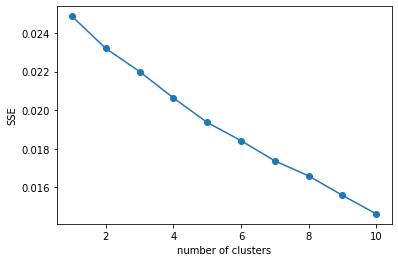

In [ ]:
## gni 내에서 클러스터링
## 최적의 k 결정 (screeplot의 elbow point에서 결정)


def elbow(X):
  """
  input X: 클러스터링할 데이터
  output: scree plot
  """
  sse = []
  for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
  
  plt.plot(range(1,11), sse, marker = "o")
  plt.xlabel("number of clusters")
  plt.ylabel("SSE")
  plt.show()

elbow(gni_embed_mat)

뚜렷한 cluster 개수가 보이지는 않는다. 대략 중간 개수인 5개 정도로 임의 설정한다.

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 0, init = 'random', n_init = 100, max_iter = 1000)
clusters = kmeans.fit_predict(gni_embed_mat)

In [ ]:
## 계층적 군집화
h_clusters = hierarchy.linkage(y = gni_embed_mat, method = 'average')

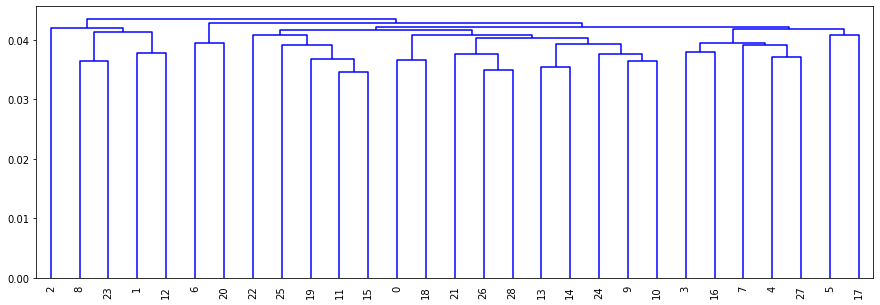

In [ ]:
plt.figure(figsize = (15,5))
hierarchy.dendrogram(h_clusters, leaf_rotation = 90)
plt.show()

In [ ]:
cutree = hierarchy.fcluster(h_clusters, t = 3, criterion = 'maxclust')
cutree

array([3, 1, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 1, 3, 3, 3, 3, 3], dtype=int32)

계층적 군집화의 경우 임의로 3개의 cluster로 분류하도록 cut tree를 설정하였다.

-- 클러스터링 시각화

In [ ]:
# pca로 차원축소
pca = PCA(n_components = 2)
gni_pca = pca.fit_transform(gni_embed_mat)

In [ ]:
# tsne으로 차원축소
tsne = TSNE() # n_components default: 2
gni_reduced = tsne.fit_transform(gni_embed_mat)

In [ ]:
## data frame화 해야함.

gni_df = pd.DataFrame({'x': gni_reduced[:,0], 'y': gni_reduced[:,1],'x2': gni_pca[:,0], 'y2': gni_pca[:,1], 'cluster_id' : clusters, 'cluster_id_h': cutree})

Text(0.5, 1.0, 'k-means on t-sne')

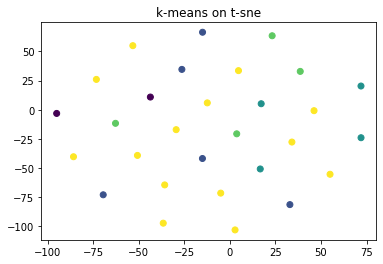

In [ ]:
plt.scatter(gni_df['x'], gni_df['y'], c = gni_df['cluster_id'])
plt.title("k-means on t-sne")

Text(0.5, 1.0, 'k-means on pca')

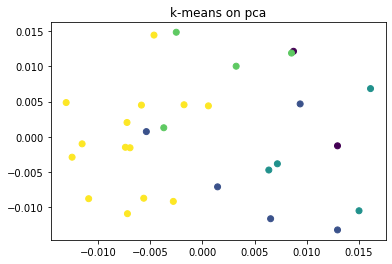

In [ ]:
plt.scatter(gni_df['x2'], gni_df['y2'], c = gni_df['cluster_id'])
plt.title("k-means on pca")

시각화 결과를 보면, clustering이 제대로 되지 않았음을 알 수 있다. 또한 t-sne으로 축소된 plot을 볼 때 뚜렷한 클러스터가 관찰되지 못했다. (뭉쳐있는 데이터와 노이즈 2개 발견) 29개의 document가 너무 적기에 클러스터링이 제대로 되지 않았을 가능성 & 데이터 간의 클러스터가 관측되지 못했을 가능성이 크다.


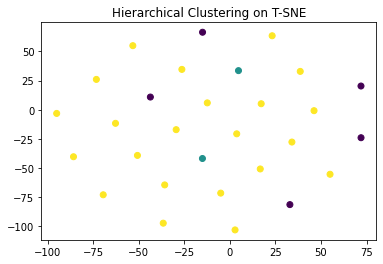

In [ ]:
plt.title("Hierarchical Clustering on T-SNE")
plt.scatter(gni_df['x'], gni_df['y'], c = gni_df['cluster_id_h'])

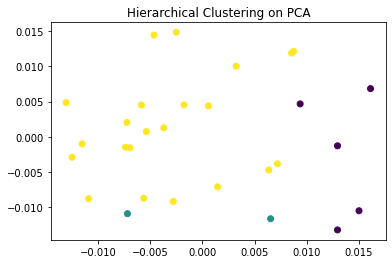

In [ ]:
plt.title("Hierarchical Clustering on PCA")
plt.scatter(gni_df['x2'], gni_df['y2'], c = gni_df['cluster_id_h'])

K-Means 결과보다는 낫지만 여전히 노이즈가 존재하고 있음을 알 수 있다.

- 클러스터 의미

In [ ]:
embed_df = pd.DataFrame(gni_embed_mat)

In [ ]:
embed_df['cluster'] = clusters
embed_df['cluster_h'] = cutree

In [ ]:
cluster_mean = np.array(embed_df.drop(['cluster_h'], axis = 1).groupby('cluster').mean())
cluster_h_mean = np.array(embed_df.drop(['cluster'], axis = 1).groupby('cluster_h').mean())

# k-means cluster 별 키워드 뽑기
for i in range(len(cluster_mean)):
  print(f"\nCluster {i}")
  print(get_most_similar_top_n(gni_embed, cluster_mean[i], gni_embed.wv.vectors, 10))


Cluster 0
['heterogeneity' 'copy' 'significance' 'antibiotic' 'argonaute'
 'characterize' 'interactively' 'predict' 'success' 'due']

Cluster 1
['investigation' 'protégé' 'domain' 'examined' 'technical' 'average'
 'holo' 'element' 'transcription' 'pdb']

Cluster 2
['developmental' 'likelihood' 'place' 'location' 'current' 'inspected'
 'robust' 'stored' 'light' 'facilitates']

Cluster 3
['healthy' 'could' 'holo' 'recently' 'rna' 'critical' 'survive' 'gene'
 'expertise' 'decoding']

Cluster 4
['ubiquitous' 'disease' 'long' 'mean' 'specific' 'hpv18' 'reportedly'
 'pkr' 'certain' 'reductase']


In [ ]:
for i in range(len(cluster_h_mean)):
  print(f"\nCluster {i}")
  print(get_most_similar_top_n(gni_embed, cluster_h_mean[i], gni_embed.wv.vectors, 10))


Cluster 0
['knowledge' 'need' 'residual' 'success' 'lineage' 'kinase' 'simulation'
 'report' 'area' 'outside']

Cluster 1
['structure' 'measured' 'table' 'including' 'biogenesis' 'researcher'
 'involved' 'arcgis' 'play' 'harvested']

Cluster 2
['disease' 'sample' 'mean' 'ubiquitous' 'hpv18' 'specific' 'landrace'
 'reportedly' 'long' 'metabolic']


In [ ]:
print([gni_embed.wv.similar_by_vector(center, topn = 1) for center in kmeans.cluster_centers_])

[[('heterogeneity', 0.30300700664520264)], [('investigation', 0.3335883915424347)], [('developmental', 0.31901589035987854)], [('healthy', 0.3382541835308075)], [('ubiquitous', 0.35900774598121643)]]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


#### 다른 저널 하나를 더 골라 위의 작업을 다시 수행함. 저널 내 paper 수가 1497개로 가장 많은 7번째 저널인 'Nucleic Acids Research'을 택함.

In [ ]:
nar_embed = d2v_list[7]
nar_embed_mat = nar_embed.docvecs.vectors_docs

- 유사도

In [ ]:
# 저널 내 paper 간 유사도
print(list(map(lambda x: d2v_list[7].docvecs.most_similar(x)[0][0], range(0,len(papers_tokens[7])))))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['628', '1244', '361', '1323', '1244', '1022', '97', '361', '1336', '925', '142', '1248', '618', '285', '930', '549', '1321', '1244', '235', '46', '611', '45', '298', '1034', '46', '628', '28', '1336', '453', '1369', '1033', '349', '46', '142', '1248', '558', '317', '1375', '18', '76', '1452', '45', '46', '1025', '52', '46', '361', '361', '1022', '825', '1160', '1248', '387', '421', '387', '528', '424', '1244', '99', '913', '1145', '76', '361', '692', '1336', '938', '1339', '1349', '97', '1159', '1380', '1487', '1327', '361', '1244', '1244', '1244', '1336', '169', '46', '286', '1458', '1449', '901', '711', '195', '1145', '1033', '1067', '32', '235', '690', '1336', '161', '1034', '1378', '611', '46', '287', '1336', '109', '142', '370', '1446', '45', '410', '1019', '287', '1244', '46', '1076', '66', '472', '378', '340', '118', '1339', '1241', '361', '1306', '183', '177', '144', '673', '1336', '145', '855', '381', '1339', '1487', '855', '4', '1396', '308', '1339', '1430', '287', '46', '42

1번째와 1244번째 paper를 비교해보자 (결과는 코드를 실행할 때마다 달라질 수 있음.)

In [ ]:
papers[7][1]

'We have recently identified lens epithelium-derived growth factor (LEDGF/p75, also known as PSIP1) as a component of the homologous recombination DNA repair machinery. Through its Pro-Trp-Trp-Pro (PWWP) domain, LEDGF/p75 binds to histone marks associated with active transcription and promotes DNA end resection by recruiting DNA endonuclease retinoblastoma-binding protein 8 (RBBP8/CtIP) to broken DNA ends. Here we show that the structurally related PWWP domain-containing protein, hepatoma-derived growth factor-related protein 2 (HDGFRP2), serves a similar function in homologous recombination repair. Its depletion compromises the survival of human U2OS osteosarcoma and HeLa cervix carcinoma cells and impairs the DNA damage-induced phosphorylation of replication protein A2 (RPA2) and the recruitment of DNA endonuclease RBBP8/CtIP to DNA double strand breaks. In contrast to LEDGF/p75, HDGFRP2 binds preferentially to histone marks characteristic for transcriptionally silent chromatin. Acco

In [ ]:
papers[7][1244]

"Synthetic biology seeks to envision living cells as a matter of engineering. However, increasing evidence suggests that the genetic load imposed by the incorporation of synthetic devices in a living organism introduces a sort of unpredictability in the design process. As a result, individual part characterization is not enough to predict the behavior of designed circuits and thus, a costly trial-error process is eventually required. In this work, we provide a new theoretical framework for the predictive treatment of the genetic load. We mathematically and experimentally demonstrate that dependences among genes follow a quantitatively predictable behavior. Our theory predicts the observed reduction of the expression of a given synthetic gene when an extra genetic load is introduced in the circuit. The theory also explains that such dependence qualitatively differs when the extra load is added either by transcriptional or translational modifications. We finally show that the limitation 

1번째 paper는 protein, homologous recombination repair에 관한 내용이고, 1244번째 paper는 tumor와 RNF168 간의 관계에 다루고 있음을 알 수 있다. 큰 관련이 있는지는 파악하기 힘들다.

In [ ]:
# paper vs word vector --> trying to interpret document vector

In [ ]:
get_most_similar_top_n(nar_embed, nar_embed_mat[1067], nar_embed.wv.vectors, n = 20)

array(['strand', 'loss', 'upon', 'end', 'kinase', 'methyltransferase',
       'formation', 'molecule', 'particle', 'mutant', 'thus', 'relative',
       'ability', 'transfer', 'double', 'cause', 'work', 'nucleotide',
       'chromosomal', 'assay'], dtype='<U30')

get_most_similar_top_n 함수를 활용하여 1067번째 paper와 nar_embed의 word embedding 벡터와의 유사도를 계산하여 가장 높은 유사도를 갖는 20개를 도출했지만, 1067번째에서 중요한 keyword인 heterogeniety, tumor, deregulation, rnf168, brca1 과는 거리가 멀어보인다. 또한 추출된 20개 중 몇몇을 제외하고는 매우 일반적인 키워드였음을 알 수 있다.

- 클러스터링

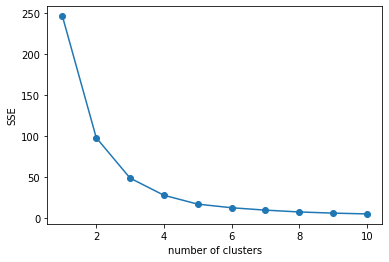

In [ ]:
elbow(nar_embed_mat)

최적의 클러스터 개수는 3

In [ ]:
kmeans = KMeans(n_clusters = 3)
clusters_nar = kmeans.fit_predict(nar_embed_mat)

In [ ]:
## pca 축에 cluster 시각화

nar_pca = pca.fit_transform(nar_embed_mat)

In [ ]:
nar_df = pd.DataFrame({'x': nar_pca[:, 0], 'y': nar_pca[:,1], 'kmeans_cluster': clusters_nar})
nar_df.head()

,x,y,kmeans_cluster
0,0.175176,0.004121,1
1,0.212569,-0.010469,1
2,0.514617,0.006092,1
3,-0.614162,-0.000961,2
4,0.622804,-0.007905,1


Text(0.5, 1.0, 'K-means clusters visualized on PCA axes')

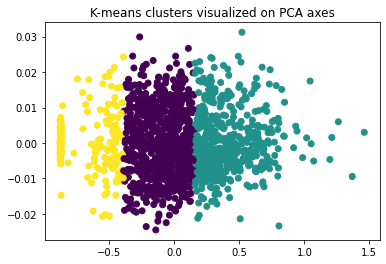

In [ ]:
plt.scatter(nar_df['x'], nar_df['y'], c= nar_df['kmeans_cluster'])
plt.title("K-means clusters visualized on PCA axes")

클러스터 간 경계가 뚜렷하다.

- 클러스터 의미 해석

In [ ]:
nar_embed_df = pd.DataFrame(nar_embed_mat)
nar_embed_df['cluster_id'] = clusters_nar
nar_embed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_id
0,0.203493,-0.077759,-0.149116,-0.047098,-0.107203,-0.076934,-0.059764,-0.119797,-0.078129,-0.003014,0.134480,0.133438,0.084614,-0.167063,0.077654,0.012499,-0.170314,-0.011509,0.053162,0.090564,0.058136,-0.112251,-0.054969,0.083505,-0.130855,-0.071813,0.034258,-0.017106,-0.006119,0.129691,0.008587,-0.012194,-0.247629,-0.049596,0.074497,0.086831,0.016520,0.074851,0.067235,0.029174,...,0.067421,0.132622,-0.130125,0.023029,0.018854,-0.070501,-0.192337,0.084725,-0.015128,-0.055235,0.138206,-0.165332,-0.189161,-0.073174,-0.088149,0.153219,-0.174037,-0.017089,-0.058445,-0.033307,0.014903,-0.221484,0.133348,0.114512,0.043287,0.094583,-0.044926,-0.031486,-0.118655,-0.089986,0.057083,-0.052018,0.039505,-0.013699,-0.019429,0.031795,0.108472,0.233419,-0.080095,1
1,0.204993,-0.085234,-0.147209,-0.053307,-0.116653,-0.082585,-0.060496,-0.117895,-0.090619,-0.005106,0.136571,0.136876,0.088002,-0.173832,0.071462,0.020125,-0.173975,-0.020253,0.052153,0.098259,0.058249,-0.114039,-0.051944,0.088758,-0.139557,-0.073139,0.042106,-0.022455,-0.001703,0.134067,0.004255,-0.008975,-0.253859,-0.051806,0.081481,0.094662,0.027408,0.069886,0.065266,0.035634,...,0.058975,0.132904,-0.133334,0.033320,0.023160,-0.081755,-0.202331,0.088595,-0.023364,-0.042751,0.145675,-0.169726,-0.191293,-0.083550,-0.092365,0.151799,-0.187895,-0.019443,-0.060360,-0.027883,0.013296,-0.231233,0.142851,0.118931,0.042397,0.099757,-0.050583,-0.029666,-0.127328,-0.094914,0.054636,-0.050894,0.044720,-0.015913,-0.019596,0.039011,0.117057,0.245392,-0.082145,1
2,0.266893,-0.104458,-0.190337,-0.065918,-0.139335,-0.103197,-0.071784,-0.156488,-0.108535,-0.013028,0.173328,0.185252,0.111976,-0.216622,0.102437,0.028983,-0.228825,-0.023040,0.071506,0.125028,0.072136,-0.146900,-0.068184,0.111508,-0.172857,-0.087304,0.053750,-0.030314,-0.003175,0.169717,0.010280,-0.015916,-0.321948,-0.065215,0.104555,0.122888,0.032135,0.096065,0.080925,0.035346,...,0.085594,0.172536,-0.167977,0.034155,0.028332,-0.096336,-0.260526,0.112047,-0.020222,-0.067004,0.183820,-0.218083,-0.247318,-0.095893,-0.123615,0.197840,-0.230693,-0.030126,-0.082508,-0.038804,0.024357,-0.294804,0.180416,0.149685,0.057239,0.131410,-0.063275,-0.040922,-0.165041,-0.123169,0.071967,-0.073063,0.056044,-0.012696,-0.023757,0.049291,0.149286,0.312707,-0.114067,1
3,0.050499,-0.016089,-0.038469,-0.014729,-0.031200,-0.015020,-0.012632,-0.026434,-0.020855,-0.004037,0.032355,0.035884,0.023373,-0.042281,0.018526,0.000077,-0.045218,-0.002593,0.014754,0.018107,0.017955,-0.030856,-0.013948,0.026144,-0.027672,-0.012067,0.010511,-0.005950,-0.002859,0.034987,0.005967,0.000259,-0.059109,-0.010495,0.018598,0.017912,0.004659,0.018253,0.013602,0.009294,...,0.011801,0.029771,-0.031349,0.007370,0.004725,-0.019629,-0.051912,0.021643,-0.006061,-0.016624,0.033324,-0.036240,-0.042393,-0.020782,-0.021193,0.038752,-0.045811,-0.007441,-0.018416,-0.009012,-0.000139,-0.054945,0.032077,0.032687,0.015468,0.025802,-0.013219,-0.011214,-0.031510,-0.025815,0.014236,-0.014053,0.005754,-0.003599,-0.007147,0.010114,0.025472,0.055659,-0.017777,2
4,0.282991,-0.120289,-0.207667,-0.073046,-0.153374,-0.116082,-0.081070,-0.170240,-0.119721,-0.013123,0.196385,0.193429,0.122314,-0.232547,0.105208,0.029450,-0.247287,-0.019115,0.075757,0.135111,0.081885,-0.157180,-0.076125,0.129081,-0.187156,-0.103610,0.060903,-0.028740,-0.011826,0.176855,0.007556,-0.013204,-0.345200,-0.073453,0.102223,0.127765,0.031235,0.104135,0.095136,0.044185,...,0.088063,0.193861,-0.181522,0.042403,0.032163,-0.111373,-0.275025,0.119694,-0.025395,-0.059714,0.201649,-0.234789,-0.261649,-0.112729,-0.131532,0.213038,-0.255407,-0.027948,-0.090750,-0.045365,0.023185,-0.321071,0.194871,0.168239,0.063985,0.148925,-0.061933,-0.041102,-0.171962,-0.132757,0.079742,-0.076802,0.059060,-0.020

In [ ]:
cluster_mean = np.array(nar_embed_df.groupby('cluster_id').mean())

# k-means cluster 별 키워드 뽑기
for i in range(len(cluster_mean)):
  print(f"\nCluster {i}")
  print(get_most_similar_top_n(nar_embed, cluster_mean[i], nar_embed.wv.vectors, 5))


Cluster 0
['mutant' 'well' 'furthermore' 'group' 'one']

Cluster 1
['one' 'mutant' 'addition' 'furthermore' 'well']

Cluster 2
['well' 'including' 'class' 'virus' 'demonstrated']


부사 등의 document의 특징을 나타낸다고 말하기 어려운 keyword들이 도출되었다. doc2vec은 기본적으로 max_count 등을 조절하지는 않기 때문에 document 별로 특징이 뚜렷이 구분되는 word를 위와 같은 방법(document 벡터 값과 word 벡터의 유사도 추출)으로 추출해내기는 어려워 보인다.

#### 2. journal별 (paper 구분 X)

In [ ]:
# journal 별 임베딩

tagged_doc = [TaggedDocument(journal, [str(idx)]) for idx, journal in enumerate(journal_tokens)]
journal_d2v = train_doc2vec(tagged_doc)

In [ ]:
print(journal_tokens[0])

['signaling', 'pathway', 'play', 'important', 'role', 'life', 'process', 'cell', 'growth', 'cell', 'apoptosis', 'organism', 'development', 'present', 'signal', 'transduction', 'network', 'far', 'complete', 'effective', 'complement', 'experimental', 'method', 'computational', 'modeling', 'suited', 'rapidly', 'reconstruct', 'signaling', 'pathway', 'low', 'cost', 'knowledge', 'existing', 'computational', 'method', 'seldom', 'simultaneously', 'exploit', 'three', 'signaling', 'pathway', 'one', 'predictive', 'model', 'discovery', 'novel', 'signaling', 'component', 'modeling', 'signaling', 'pathway', 'work', 'propose', 'transfer', 'learning', 'method', 'simultaneously', 'reconstruct', 'human', 'signaling', 'pathway', 'model', 'computational', 'result', 'show', 'proposed', 'method', 'demonstrates', 'satisfactory', 'learning', 'performance', 'rational', 'prediction', 'predicted', 'signaling', 'component', 'pathway', 'targeted', 'protein', 'validated', 'recent', 'literature', 'predicted', 'signa

In [ ]:
journal_d2v.docvecs.vectors_docs.shape # 12개의 document가 embedding이 된 걸 알 수 있음

(12, 100)

In [ ]:
journal_embed_mat = journal_d2v.docvecs.vectors_docs

In [ ]:
# journal 간 유사도

list(map(lambda x: journal_d2v.docvecs.most_similar(x, topn = 2), range(len(tagged_doc)))) 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[[('5', 0.9999127388000488), ('2', 0.9999092817306519)],
 [('4', 0.9999774098396301), ('10', 0.999963104724884)],
 [('11', 0.9999866485595703), ('4', 0.9999822378158569)],
 [('9', 0.9999701976776123), ('1', 0.9999575614929199)],
 [('11', 0.9999878406524658), ('2', 0.9999822378158569)],
 [('11', 0.9999675154685974), ('2', 0.9999642372131348)],
 [('1', 0.9999372959136963), ('10', 0.9999145269393921)],
 [('1', 0.9999321699142456), ('9', 0.9999239444732666)],
 [('4', 0.9999481439590454), ('1', 0.999929666519165)],
 [('3', 0.9999701976776123), ('10', 0.9999650716781616)],
 [('9', 0.9999649524688721), ('4', 0.9999644160270691)],
 [('4', 0.9999879002571106), ('2', 0.9999866485595703)]]

In [ ]:
journal_list

['BMC Bioinformatics',
 'Genomics & Informatics',
 'Algorithms for Molecular Biology : AMB',
 'BMC Systems Biology',
 'Journal of Computational Biology',
 'Briefings in Bioinformatics',
 'BMC Genomics',
 'Nucleic Acids Research',
 'American Journal of Human Genetics',
 'Oncogenesis',
 'Disease Markers',
 'Microarrays']

In [ ]:
journal_d2v.docvecs.most_similar('2', topn = 12)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('11', 0.9999866485595703),
 ('4', 0.9999822378158569),
 ('5', 0.99996417760849),
 ('1', 0.9999512434005737),
 ('8', 0.9999255537986755),
 ('10', 0.9999219179153442),
 ('0', 0.9999092817306519),
 ('9', 0.9998867511749268),
 ('3', 0.9998766779899597),
 ('7', 0.9998701810836792),
 ('6', 0.9998414516448975)]

각 문서가 서로 유사도가 높게 나옴을 알 수 있다. --> journal을 label로 하는 것이 의미가 있을까?

In [ ]:
# pca를 이용해서 2차원으로 축소한 데이터 공간에 각 document를 plotting

pca = PCA(n_components=2)
journal_pca = pca.fit_transform(journal_embed_mat)

In [ ]:
j_pca_df = pd.DataFrame({'x':journal_pca[:,0], 'y':journal_pca[:,1]})
j_pca_df['journal_label'] = range(12)

In [ ]:
journal_label = {k:v for k, v in zip(j_pca_df['journal_label'], journal_list)}
j_pca_df['journal_label_str'] = j_pca_df['journal_label'].map(journal_label)

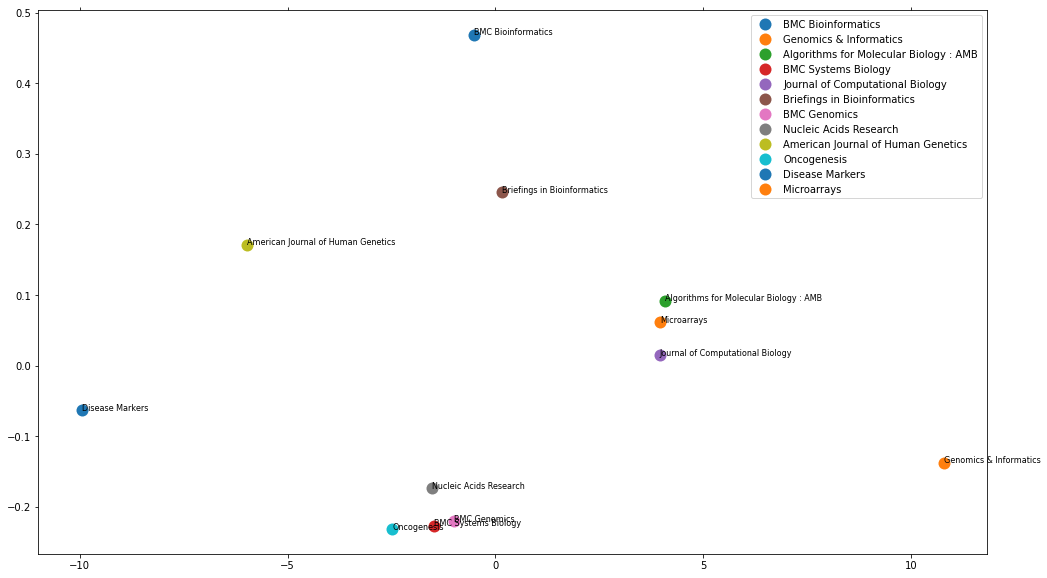

In [ ]:
fig, ax = plt.subplots(figsize=(17,10))

groups = j_pca_df.groupby('journal_label')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=journal_label[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(j_pca_df)):
    ax.text(j_pca_df.iloc[i]['x'], j_pca_df.iloc[i]['y'], j_pca_df.iloc[i]['journal_label_str'], size=8)

journal 별로 plotting한 결과는 위와 같다. 몇몇 document의 거리가 매우 가까움을 알 수 있다. clustering을 했을 때 유의미한 결과가 나올지 clustering을 해보도록 한다.

- 클러스터링

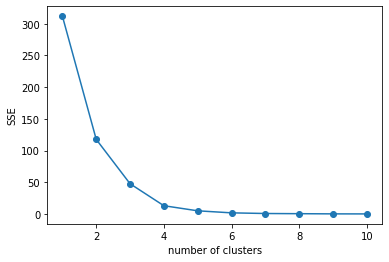

In [ ]:
elbow(journal_embed_mat)

최적의 클러스터 개수는 역시 2~3개 정도로 결정 가능하다. 여기서는 3개로 결정하도록 한다.

In [ ]:
# fitting k-means
kmeans = KMeans(n_clusters = 3)
cluster_k = kmeans.fit_predict(journal_embed_mat)

In [ ]:
j_pca_df['cluster'] = cluster_k

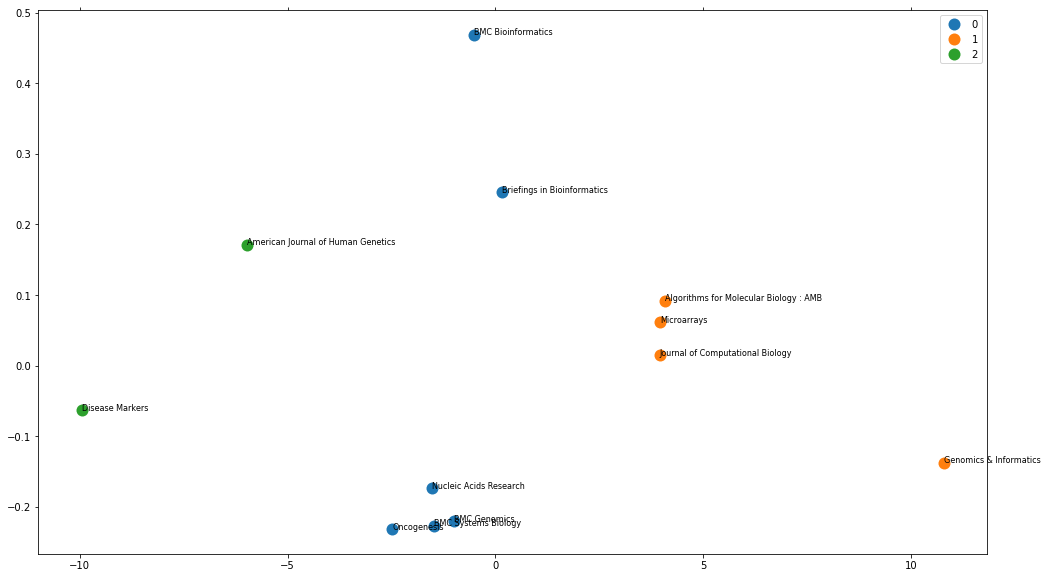

In [ ]:
# visualization

fig, ax = plt.subplots(figsize=(17,10))

groups = j_pca_df.groupby('cluster')


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=name, 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(j_pca_df)):
    ax.text(j_pca_df.iloc[i]['x'], j_pca_df.iloc[i]['y'], j_pca_df.iloc[i]['journal_label_str'], size=8)

위와 같이 클러스터링이 되었다. G&I는 동일 클러스터에 속하는 다른 저널과는 조금 떨어져있으나 같은 그룹으로 분류되었다. 또한, cluster2의 경우에는 클러스터 내에 속하는 journal끼리 거리가 꽤 멀다. 그러나 클러스터의 경계는 매우 뚜렷하므로 클러스터 결과가 나쁘다고 하기는 힘들다.

### journal 분류 모델

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text

In [ ]:
# journal로 label 만들기
label = 0
label_list = []
for i in range(len(papers)):
  for j in range(len(papers[i])):
    label_list.append(label)
  label+=1

In [ ]:
len(label_list) == sum(map(lambda x: len(x), papers))

True

input으로는 각각 정수 인코딩된 단어 토큰을 갖는 sequence의 집합 (sequence ==> 하나의 document라고 생각하면 쉬울 듯함)


#### label 분류 학습

In [ ]:
X = np.array(list(itertools.chain.from_iterable(papers)))
y = np.array(label_list)

In [ ]:
len(X), len(y)

(4186, 4186)

In [ ]:
# 정수 인코딩
keras_tokenizer = text.Tokenizer()
keras_tokenizer.fit_on_texts(X) # keras tokenizer를 이용하여 tokenize
sequences = keras_tokenizer.texts_to_sequences(X)
X = sequences # update X

정수 인코딩을 보다 용이하게 진행하기 위해 keras의 내장 tokenizer로 토크나이징을 진행

In [ ]:
word_to_idx = keras_tokenizer.word_index
print(word_to_idx) # 빈도수 정렬 후 인덱스를 부여했음을 알 수 있다.

{'the': 1, 'of': 2, 'and': 3, 'in': 4, 'to': 5, 'a': 6, 'for': 7, 'that': 8, 'is': 9, 'we': 10, 'with': 11, 'by': 12, 'are': 13, 'as': 14, 'from': 15, 'genes': 16, 'this': 17, 'on': 18, 'were': 19, 'gene': 20, 'data': 21, 'an': 22, 'expression': 23, 'be': 24, 'analysis': 25, 'was': 26, 'these': 27, 'which': 28, 'dna': 29, 'have': 30, 'genome': 31, 'or': 32, 'at': 33, 'our': 34, 'protein': 35, 'can': 36, 'using': 37, 'rna': 38, 'between': 39, 'based': 40, 'two': 41, 'study': 42, 'also': 43, 'identified': 44, 'their': 45, 'has': 46, 'results': 47, 'cell': 48, 'high': 49, 'been': 50, 'different': 51, 'not': 52, 'binding': 53, 'sequence': 54, 'sequencing': 55, 'methods': 56, 'specific': 57, 'used': 58, 'it': 59, '1': 60, 'cells': 61, 'other': 62, 'proteins': 63, 'associated': 64, 'both': 65, 'more': 66, 'model': 67, 'human': 68, 'genetic': 69, 'such': 70, 'method': 71, 'cancer': 72, 'species': 73, 'its': 74, 'than': 75, 'however': 76, 'into': 77, 'here': 78, 'studies': 79, 'but': 80, 'one'

In [ ]:
## 단어 빈도 수에 대한 파악

threshold = 2
total_count = len(word_to_idx) # 총 단어 개수
rare_count = 0 # 빈도수가 threshold보다 작은 단어 개수
total_freq = 0 # 데이터 내에 전체 단어 빈도수 총합

In [ ]:
for token, freq in keras_tokenizer.word_counts.items(): # word_counts.items(): (word, freq)
  total_freq += freq

  if (freq < threshold): # 빈도수가 1
    rare_count += 1

print(f"num of rare({threshold-1} times) words in data: {rare_count}")
print(f"proportion of rare words in data: {rare_count/total_count*100}")
print(f"proprotion of rare freq from total freq: {rare_count / total_freq*100}")
# 어차피 threshold가 1이라 rare count = rare frequency

num of rare(1 times) words in data: 14553
proportion of rare words in data: 40.15839289163608
proprotion of rare freq from total freq: 1.5695913648207906


한 번만 등장하는 단어의 비율은 전체 단어 대비 40% 정도로 거의 반을 차지했다. 그러나, 전체 등장 빈도 수 대비로 했을 때의 비율은 약 1.6%로 매우 낮았다.

In [ ]:
vocab_size = len(word_to_idx) + 1 # padding을 위한 토큰인 0번 단어를 고려하여 +1을 해서 vocab_size 지정
print(vocab_size)

36240


In [ ]:
# Sequence 분포 확인
print("max length of document: {}".format(max(len(l) for l in X)))
print("average length of document: {}".format(sum(map(len, X))/len(X)))

max length of document: 587
average length of document: 221.4964166268514


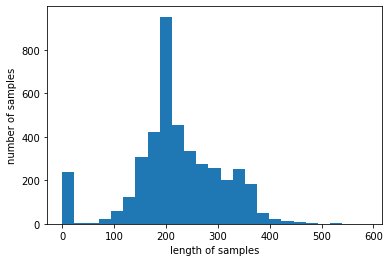

In [ ]:
plt.hist([len(s) for s in X], bins = 25)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = max(len(l) for l in X)

X_padded = sequence.pad_sequences(X, maxlen = max_len) # maxlen은 document 최대 길이에 맞춤 (그보다 작은 것은 zero padding)
print("shape of X: ", X_padded.shape)
y = pd.get_dummies(y)
print("shape of y: ", y.shape)

shape of X:  (4186, 587)
shape of y:  (4186, 12)


In [ ]:
# train test split (split 비율은 8:2)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size = .2, random_state = 0)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3348, 587) (3348, 12)
(838, 587) (838, 12)


In [ ]:
embedding_size = 100

model = Sequential([
                    Embedding(input_dim = vocab_size,
                              output_dim = embedding_size, 
                              input_length = max_len),
                    Conv1D(filters = 50, kernel_size = 5, padding = 'same', activation = 'relu'),
                    MaxPooling1D(pool_size=2),
                    LSTM(50),
                    Dropout(0.25),
                    Dense(25, activation = 'sigmoid'),
                    Dense(12, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 587, 100)          3624000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 587, 50)           25050     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 293, 50)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_16 (Dense)             (None, 12)               

In [ ]:
print("Training...")
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 64)

Training...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3348 samples, validate on 838 samples
Epoch 1/30
3348/3348 [==============================] - 26s 8ms/step - loss: 2.0086 - accuracy: 0.2855 - val_loss: 1.7752 - val_accuracy: 0.3568
Epoch 2/30
3348/3348 [==============================] - 25s 8ms/step - loss: 1.7396 - accuracy: 0.3581 - val_loss: 1.7205 - val_accuracy: 0.3568
Epoch 3/30
3348/3348 [==============================] - 25s 8ms/step - loss: 1.6896 - accuracy: 0.3611 - val_loss: 1.6750 - val_accuracy: 0.3568
Epoch 4/30
3348/3348 [==============================] - 26s 8ms/step - loss: 1.5231 - accuracy: 0.4424 - val_loss: 1.5304 - val_accuracy: 0.5000
Epoch 5/30
3348/3348 [==============================] - 28s 8ms/step - loss: 1.2922 - accuracy: 0.6042 - val_loss: 1.4275 - val_accuracy: 0.5453
Epoch 6/30
3348/3348 [==============================] - 25s 8ms/step - loss: 1.0775 - accuracy: 0.7094 - val_loss: 1.2751 - val_accuracy: 0.6241
Epoch 7/30
3348/3348 [==============================] - 26s 8ms/step - loss: 0.8818

In [ ]:
model_accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy: {}%".format(model_accuracy*100))

838/838 [==============================] - 2s 2ms/step
Test Accuracy: 61.57518029212952%
